# Learning to stabilize a linear system

For this example we demonstrate learning to stabilize a double integrator system using [Differentiable predictive control (DPC) method](https://www.sciencedirect.com/science/article/pii/S0959152422000981). 

**Differentiable Predictive Control method**:  
The DPC is a model-based policy optimization algorithm, that exploits the differentiability of a wide class of model representations for dynamical systems, including differential equations, state-space models, or various neural network architectures. In DPC, we construct a differentiable closed-loop system composed of neural control policy and system dynamics model that is to be optimized using parametric control objectives as intrinsic reward signals evaluated over a sampled distribution of the problem parameters.

<img src="./figs/DPC_simple_method.png" width="600">  

## NeuroMANCER and Dependencies

### Install (Colab only)
Skip this step when running locally.

We need to install a more recent version of matplotlib than is offered in the default Colab environment. After running the cell 1 for the first time in a new Colab runtime, you will see the prompt: "You must restart the runtime in order to use newly installed versions." After restarting, the correct version of matplotlib will be loaded for the duration of the current runtime.

In [ ]:
!pip install setuptools==61.0.0 casadi mlflow torchdiffeq dill pyts plum-dispatch==1.7.3 --user
!pip install git+https://github.com/pnnl/neuromancer.git@master --ignore-requires-python --no-deps --user

In [1]:
import torch
from neuromancer.system import Node, System
from neuromancer.modules import blocks
from neuromancer.dataset import DictDataset
from neuromancer.constraint import variable
from neuromancer.loss import PenaltyLoss
from neuromancer.problem import Problem
from neuromancer.trainer import Trainer
from neuromancer.plot import pltCL, pltPhase

# Node and System classes

The Node class is a simple wrapper for any callable pytorch function or nn.Module which provides names for the inputs and outputs to be used in composition of a potentially cyclic computational graph.  

In [2]:
# Double integrator parameters
nx = 2
nu = 1
A = torch.tensor([[1.2, 1.0],
                  [0.0, 1.0]])
B = torch.tensor([[1.0],
                  [0.5]])

# linear state space model
xnext = lambda x, u: x @ A.T + u @ B.T    
double_integrator = Node(xnext, ['X', 'U'], ['X'], name='integrator')

# neural control policy
mlp = blocks.MLP(nx, nu, bias=True,
                 linear_map=torch.nn.Linear,
                 nonlin=torch.nn.ReLU,
                 hsizes=[20, 20, 20, 20])
policy = Node(mlp, ['X'], ['U'], name='policy')

# closed loop system definition
cl_system = System([policy, double_integrator])
# cl_system.show()

# Training dataset generation

For a training dataset we randomly sample points away from the origin of the 2D space the systemn operates in. 

In [3]:
# Training dataset generation
train_data = DictDataset({'X': 3.*torch.randn(3333, 1, nx)}, name='train')  # Split conditions into train and dev
dev_data = DictDataset({'X': 3.*torch.randn(3333, 1, nx)}, name='dev')
train_loader = torch.utils.data.DataLoader(train_data, batch_size=3333,
                                           collate_fn=train_data.collate_fn, shuffle=False)
dev_loader = torch.utils.data.DataLoader(dev_data, batch_size=3333,
                                         collate_fn=dev_data.collate_fn, shuffle=False)

# Optimization problem

We want to learn a controller that stabilizes the double integrator system. In other words we would like a control policy that pushes the system to stay at the origin. 

In [4]:
# Define optimization problem
u = variable('U')
x = variable('X')
action_loss = 0.001 * (u == 0.)^2  # control penalty
regulation_loss = 10. * (x == 0.)^2  # target position
loss = PenaltyLoss([action_loss, regulation_loss], [])
problem = Problem([cl_system], loss)
optimizer = torch.optim.AdamW(policy.parameters(), lr=0.001)

# Optimize problem with a system rollout of 2 time steps


In [5]:
trainer = Trainer(
    problem,
    train_loader,
    dev_loader,
    dev_loader,
    optimizer=optimizer,
    epochs=400,
    train_metric="train_loss",
    dev_metric="dev_loss",
    eval_metric='dev_loss',
    warmup=400,
)

# Train model with prediction horizon of 2
cl_system.nsteps = 2
best_model = trainer.train()

C:\Users\drgo694\AppData\Roaming\Python\Python310\site-packages\neuromancer\constraint.py:163: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([3333, 2, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(left, right)
C:\Users\drgo694\AppData\Roaming\Python\Python310\site-packages\neuromancer\constraint.py:163: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([3333, 3, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(left, right)


epoch: 0  train_loss: 198.0162353515625
epoch: 1  train_loss: 197.2971954345703
epoch: 2  train_loss: 196.6017303466797
epoch: 3  train_loss: 195.92803955078125
epoch: 4  train_loss: 195.27279663085938
epoch: 5  train_loss: 194.63121032714844
epoch: 6  train_loss: 193.998291015625
epoch: 7  train_loss: 193.3653564453125
epoch: 8  train_loss: 192.724609375
epoch: 9  train_loss: 192.06915283203125
epoch: 10  train_loss: 191.3965301513672
epoch: 11  train_loss: 190.70285034179688
epoch: 12  train_loss: 189.9858856201172
epoch: 13  train_loss: 189.24517822265625
epoch: 14  train_loss: 188.47471618652344
epoch: 15  train_loss: 187.66917419433594
epoch: 16  train_loss: 186.82449340820312
epoch: 17  train_loss: 185.93661499023438
epoch: 18  train_loss: 185.00210571289062
epoch: 19  train_loss: 184.0167694091797
epoch: 20  train_loss: 182.97850036621094
epoch: 21  train_loss: 181.88616943359375
epoch: 22  train_loss: 180.73831176757812
epoch: 23  train_loss: 179.53663635253906
epoch: 24  train

epoch: 200  train_loss: 39.479164123535156
epoch: 201  train_loss: 39.477474212646484
epoch: 202  train_loss: 39.47582244873047
epoch: 203  train_loss: 39.474220275878906
epoch: 204  train_loss: 39.47265625
epoch: 205  train_loss: 39.47113037109375
epoch: 206  train_loss: 39.469642639160156
epoch: 207  train_loss: 39.468196868896484
epoch: 208  train_loss: 39.46678161621094
epoch: 209  train_loss: 39.46540832519531
epoch: 210  train_loss: 39.46406936645508
epoch: 211  train_loss: 39.462764739990234
epoch: 212  train_loss: 39.461490631103516
epoch: 213  train_loss: 39.46024703979492
epoch: 214  train_loss: 39.459041595458984
epoch: 215  train_loss: 39.45785903930664
epoch: 216  train_loss: 39.456703186035156
epoch: 217  train_loss: 39.45556640625
epoch: 218  train_loss: 39.45445251464844
epoch: 219  train_loss: 39.453365325927734
epoch: 220  train_loss: 39.452301025390625
epoch: 221  train_loss: 39.45124435424805
epoch: 222  train_loss: 39.450191497802734
epoch: 223  train_loss: 39.4491

epoch: 395  train_loss: 39.3997802734375
epoch: 396  train_loss: 39.39971160888672
epoch: 397  train_loss: 39.39963912963867
epoch: 398  train_loss: 39.399574279785156
epoch: 399  train_loss: 39.39950180053711


# Evaluate best model on a system rollout 


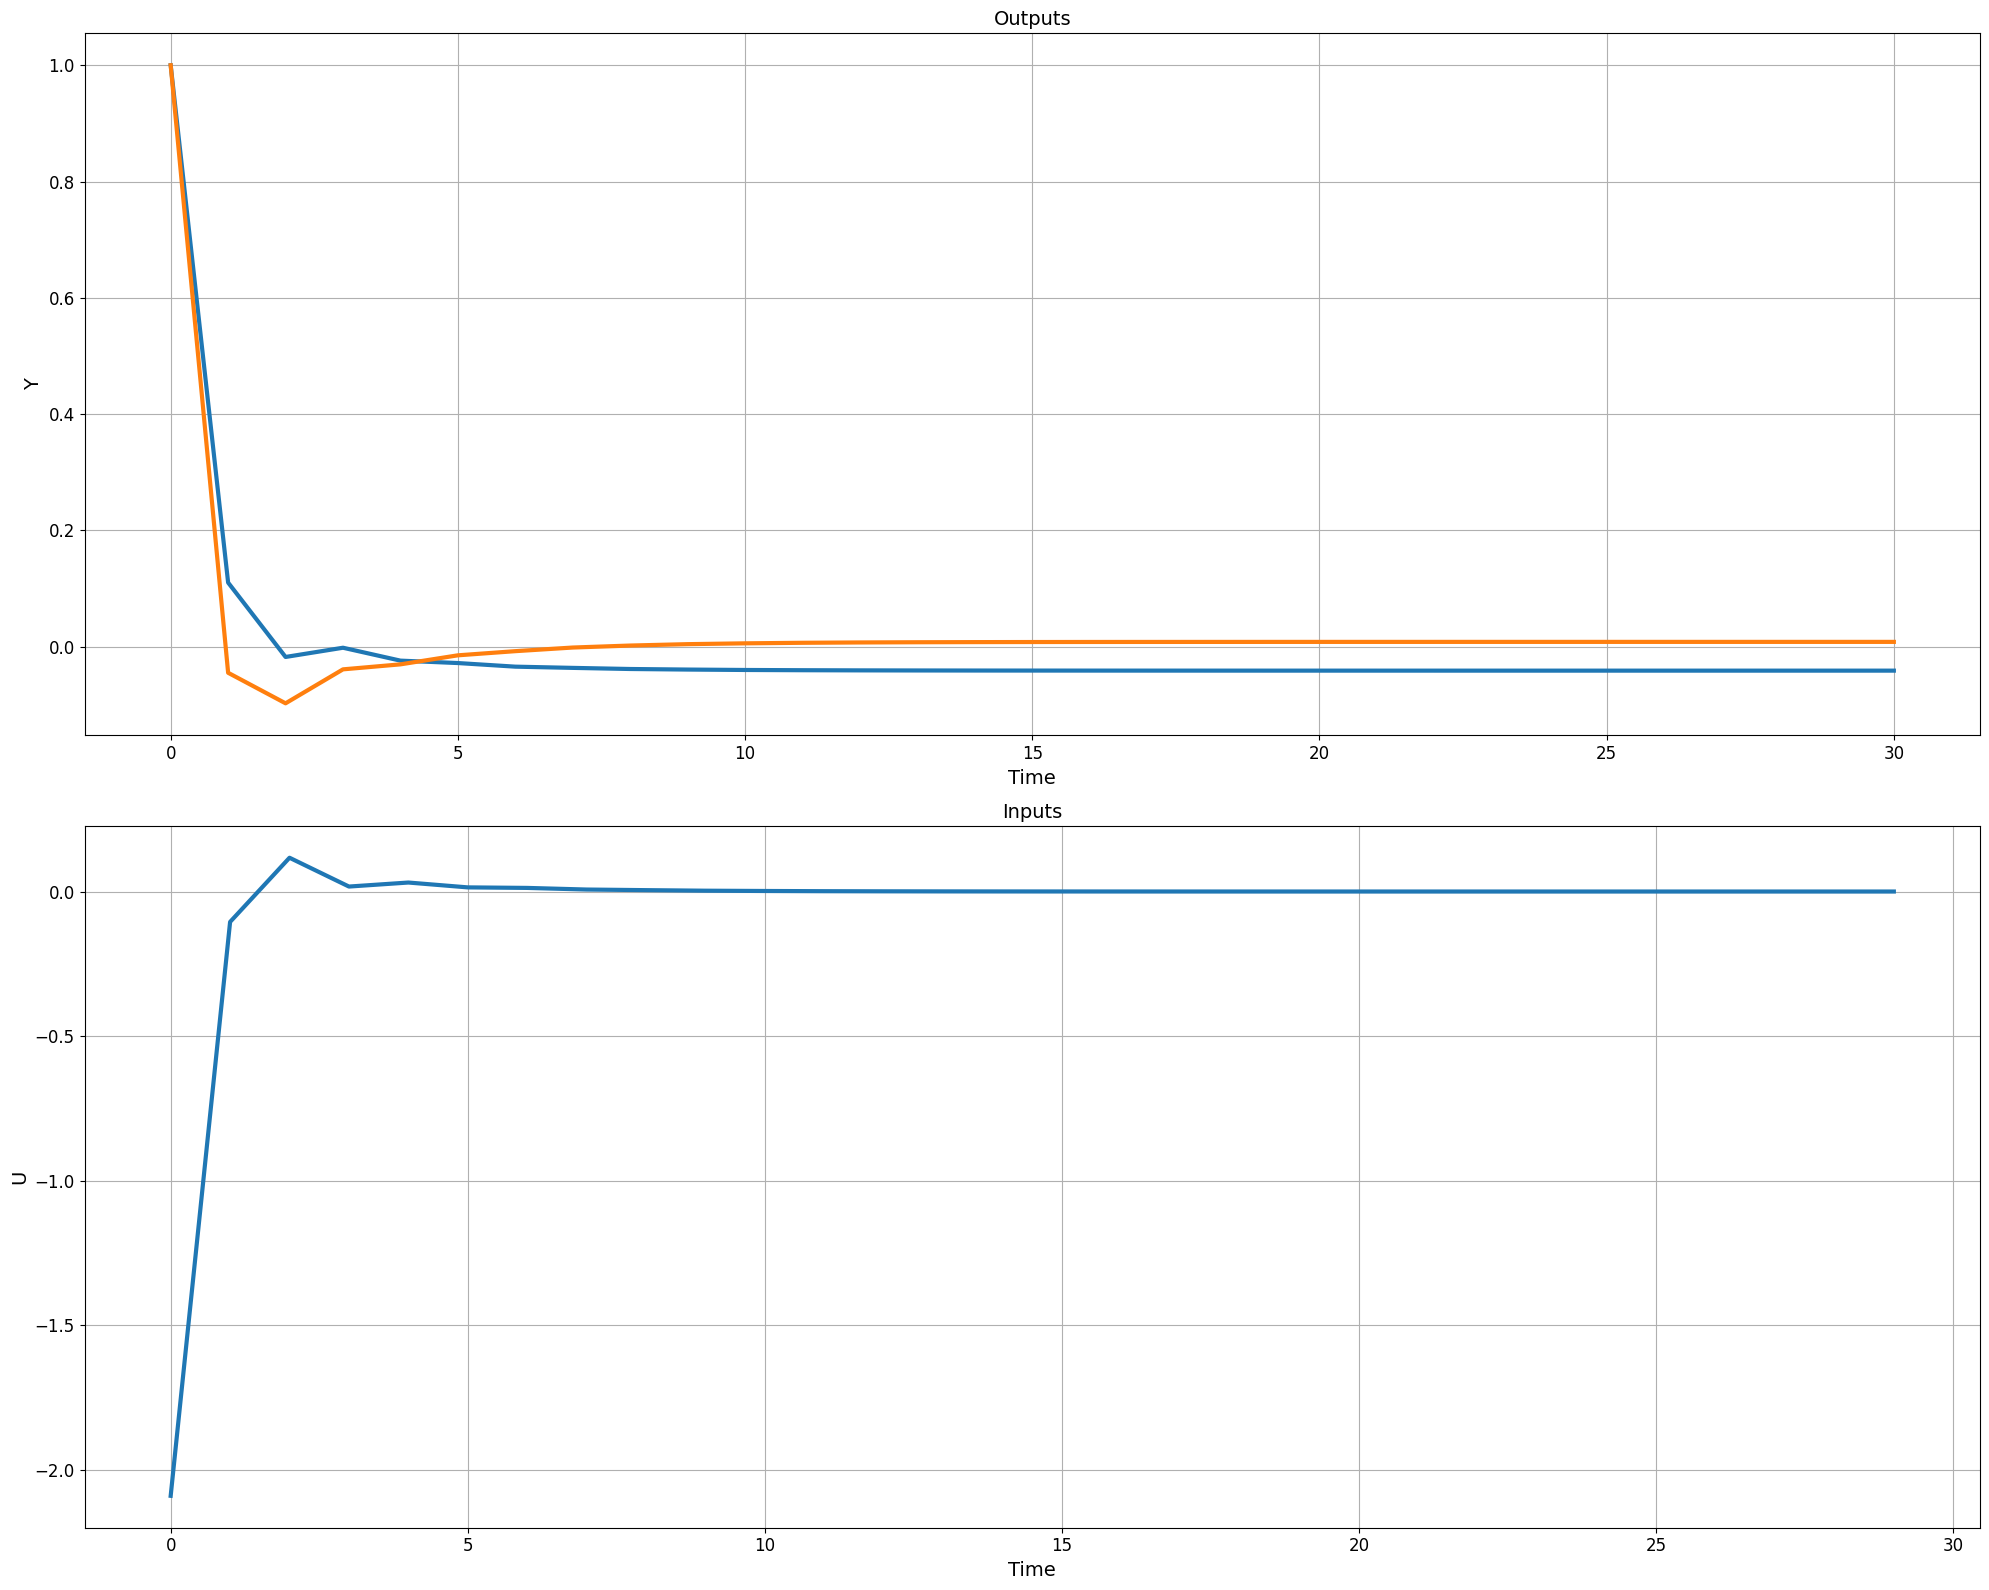

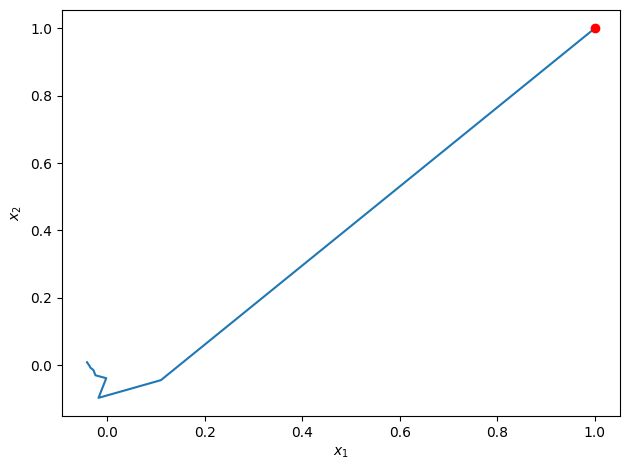

<Figure size 640x480 with 0 Axes>

In [6]:
# Test best model with prediction horizon of 50
problem.load_state_dict(best_model)
data = {'X': torch.ones(1, 1, nx, dtype=torch.float32)}
nsteps = 30
cl_system.nsteps = nsteps
trajectories = cl_system(data)
pltCL(Y=trajectories['X'].detach().reshape(nsteps+1, 2), U=trajectories['U'].detach().reshape(nsteps, 1), figname='cl.png')
pltPhase(X=trajectories['X'].detach().reshape(nsteps+1, 2), figname='phase.png')